In [23]:
from Bio.Cluster import kcluster
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import subprocess
import shutil
import glob
import time
import os
import re

### Analysis input
input="mIba1"
input_dataframe=pd.read_csv(f"output/{input}/partial_diff/diffusions/metrics.csv")

os.makedirs(f"output/{input}/filtered_sequences/filtered_binders", exist_ok=True)
input_dataframe.describe()

,index,mpnn,plddt,i_ptm,i_pae,rmsd,clusterid,ddg,rg,charge,...,ddg_score,ddg_dsasa_100,ddgscore_dsasa_100,cms,vbuns_bound,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int
count,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,...,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000,533.000000
mean,26890.249531,1.039303,0.945875,0.884705,4.738862,1.066216,13.609756,-58.637771,10.952414,-7.963232,...,-48.841488,-2.961385,-2.469290,588.624636,3.150094,2.652908,0.497186,13.679174,12.722326,0.956848
std,10958.038309,0.057260,0.004382,0.011626,0.186113,0.313222,7.459014,8.433185,0.499014,3.937924,...,6.537952,0.402812,0.335739,56.595164,1.336301,0.893574,0.898250,2.946305,2.659535,1.096823
min,46.000000,0.894408,0.940037,0.846691,4.098759,0.412210,0.000000,-86.901000,9.817754,-26.730458,...,-68.545798,-3.950414,-3.414852,382.228973,0.000000,0.000000,-1.000000,7.000000,7.000000,-2.000000
25%,22687.000000,0.999643,0.942385,0.876471,4.601694,0.844196,7.000000,-64.027000,10.741646,-9.758244,...,-53.247077,-3.270196,-2.711263,552.550171,2.000000,2.000000,0.000000,12.000000,11.000000,0.000000
50%,26439.000000,1.038784,0.944958,0.885892,4.770369,1.035173,15.000000,-59.483000,10.911811,-7.759449,...,-49.281999,-2.985110,-2.481339,582.759766,3.000000,3.000000,0.000000,13.000000,12.000000,1.000000
75%,33851.000000,1.074197,0.948543,0.893548,4.896532,1.239002,21.000000,-52.473000,11.179391,-5.450937,...,-44.794584,-2.684389,-2.262113,621.663574,4.000000,3.000000,1.000000,15.000000,14.000000,2.000000
max,48073.000000,1.246643,0.961838,0.916605,4.998763,1.967075,24.000000,-36.148000,13.991920,2.522104,...,-24.323229,-1.672540,-1.143734,871.714966,8.000000,5.000000,4.000000,25.000000,24.000000,5.000000


In [24]:
# Assuming 'df' is your input DataFrame
columns_of_interest = ["plddt", "i_pae", "rmsd", "ddg", "charge", "cms", "vbuns_int", "sbuns_int", "shape_comp", "hyd_contacts", "ddg_dsasa_100"]

# Filter the DataFrame for the existing columns and describe
description = input_dataframe[[col for col in columns_of_interest if col in input_dataframe.columns]].describe()

print(description)

            plddt       i_pae        rmsd         ddg      charge         cms  \
count  533.000000  533.000000  533.000000  533.000000  533.000000  533.000000   
mean     0.945875    4.738862    1.066216  -58.637771   -7.963232  588.624636   
std      0.004382    0.186113    0.313222    8.433185    3.937924   56.595164   
min      0.940037    4.098759    0.412210  -86.901000  -26.730458  382.228973   
25%      0.942385    4.601694    0.844196  -64.027000   -9.758244  552.550171   
50%      0.944958    4.770369    1.035173  -59.483000   -7.759449  582.759766   
75%      0.948543    4.896532    1.239002  -52.473000   -5.450937  621.663574   
max      0.961838    4.998763    1.967075  -36.148000    2.522104  871.714966   

        vbuns_int   sbuns_int  shape_comp  hyd_contacts  ddg_dsasa_100  
count  533.000000  533.000000  533.000000    533.000000     533.000000  
mean     0.497186    0.956848    0.648043      9.166979      -2.961385  
std      0.898250    1.096823    0.045514      1.76

## Filter dataframe
tipical metrics:
- plddt > 0.85-0.9
- i_pae < 5
- ddg_dsasa_100 < -2.5 - -3.5 (sort by)
additional metrics:
- charge < -2
- hyd_contacts > 4-6
- sap < 30-60

In [29]:
filtered = input_dataframe[(input_dataframe["plddt"]>0.85)&
                           (input_dataframe["i_pae"]<8)&
                           (input_dataframe["ddg"]<-50)&
                           (input_dataframe["charge"]<-1)&
                           (input_dataframe["ddg_dsasa_100"]<-2.6)&
                           #(input_dataframe["ddgscore_dsasa_100"]<-2.5)&
                           (input_dataframe["shape_comp"]>0.5)&
                           (input_dataframe["vbuns_int"]<1)&
                           (input_dataframe["cms"]>500)&
                           (input_dataframe["hyd_contacts"]>5)]
                          # (input_dataframe["sap"]<100)]#&
                           #(input_dataframe["dG"]<30)]

filtered = filtered.sort_values(by='ddg_dsasa_100', ascending=True).drop_duplicates("seq")
filtered.to_csv(f"output/{input}/filtered_sequences/0_filtered_binders.csv", index=False)
filtered.reset_index(inplace=True)
filtered

,level_0,index,mpnn,seq,plddt,i_ptm,i_pae,rmsd,model_path,input_pdb,...,ddg_score,ddg_dsasa_100,ddgscore_dsasa_100,cms,vbuns_bound,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int
0,50,23323,1.032081,QGGKLFGLLKKQQEERLEGINKQFLDDPKYSNDEDLPSKLEEFKVK...,0.952422,0.895350,4.410603,1.035173,output/mIba1/partial_diff/diffusions/batch_1/E...,output/mIba1/partial_diff/diffusions/batch_1/E...,...,-51.323583,-3.741140,-2.887957,556.595093,3.0,3.0,0.0,12.0,11.0,1.0
1,300,24978,1.128812,QGGKLFGLLKKQQEERLEGINKQFLDDPKYSNDEDLPSKLEEFKVK...,0.944240,0.871759,4.707317,1.315270,output/mIba1/partial_diff/diffusions/batch_1/G...,output/mIba1/partial_diff/diffusions/batch_1/G...,...,-58.366025,-3.674092,-3.162817,597.455688,3.0,3.0,0.0,8.0,8.0,0.0
2,210,15884,1.108289,QGGKLFGLLKKQQEERLEGINKQFLDDPKYSNDEDLPSKLEEFKVK...,0.946552,0.898597,4.655358,0.985224,output/mIba1/partial_diff/diffusions/batch_1/4...,output/mIba1/partial_diff/diffusions/batch_1/4...,...,-55.894345,-3.671225,-2.653435,621.924683,3.0,3.0,0.0,9.0,9.0,0.0
3,125,26662,0.993156,QGGKLFGLLKKQQEERLEGINKQFLDDPKYSNDEDLPSKLEEFKVK...,0.948836,0.887750,4.601694,0.640169,output/mIba1/partial_diff/diffusions/batch_1/E...,output/mIba1/partial_diff/diffusions/batch_1/E...,...,-56.210557,-3.631107,-3.179131,557.978088,2.0,2.0,0.0,12.0,10.0,2.0
4,290,47219,1.146666,QGGKLFGLLKKQQEERLEGINKQFLDDPKYSNDEDLPSKLEEFKVK...,0.944422,0.864657,4.896761,1.801143,output/mIba1/partial_diff/diffusions/batch_1/X...,output/mIba1/partial_diff/diffusions/batch_1/X...,...,-51.201177,-3.612610,-2.621975,583.567749,1.0,1.0,0.0,12.0,11.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,117,638,1.041257,QGGKLFGLLKKQQEERLEGINKQFLDDPKYSNDEDLPSKLEEFKVK...,0.949162,0.899458,4.748882,1.078475,output/mIba1/partial_diff/diffusions/batch_1/0...,output/mIba1/partial_diff/diffusions/batch_1/0...,...,-47.953523,-2.633211,-2.454977,589.705566,2.0,2.0,0.0,15.0,13.0,2.0
203,126,32369,0.978103,QGGKLFGLLKAQQEERLEGINKQFLDDPKYSNDEDLPSKLEEFKVK...,0.948831,0.912059,4.551086,1.265126,output/mIba1/partial_diff/diffusions/batch_1/K...,output/mIba1/partial_diff/diffusions/batch_1/K...,...,-57.532284,-2.626206,-2.610023,610.240112,3.0,3.0,0.0,12.0,12.0,0.0
204,429,36239,0.994789,QGGKLFGLLKKQQEERLEGINKQFLDDPKYSNDEDLPSKLEEFKVK...,0.941700,0.892332,4.825928,1.020113,output/mIba1/partial_diff/diffusions/batch_1/K...,output/mIba1/partial_diff/diffusions/batch_1/K...,...,-53.597064,-2.625369,-2.700756,590.925598,1.0,1.0,0.0,16.0,15.0,1.0
205,64,34072,1.103700,QGGKLFGLLKQQQEERLEGINKQFLDDPKYSNDEDLPSKLEEFKVK...,0.951298,0.901186,4.553677,0.859629,output/mIba1/partial_diff/diffusions/batch_1/K...,output/mIba1/partial_diff/diffusions/batch_1/K...,...,-53.902103,-2.612704,-2.754680,598.104309,2.0,2.0,0.0,12.0,12.0,0.0


In [32]:
# Calculate statistics on scaffolds
scaffold_counts = filtered["diff"].value_counts()
total_unique_scaffolds = len(scaffold_counts)
total_scaffold_instances = scaffold_counts.sum()

print("Total unique diffusions:", total_unique_scaffolds)
print("Total diffusion instances:", total_scaffold_instances)
print("\nDiffusion counts:")
print(scaffold_counts)

Total unique diffusions: 19
Total diffusion instances: 207

Diffusion counts:
X0JT    26
AKV0    21
UFUC    21
O3SD    21
J02N    19
EOB5    18
NKIN    16
KV4F    13
1VW7    11
TTLO    10
GZCR     8
3FRX     5
0CYM     4
CDNV     4
4TJP     3
Z4Z8     3
8C7K     2
3B7D     1
1KQQ     1
Name: diff, dtype: int64


In [33]:
def repeat_rows_by_column_value(df, column_name, number):
    unique_values = df[column_name].unique()
    repeated_rows = []

    for value in unique_values:
        subset = df[df[column_name] == value]
        num_repeats = min(number, subset.shape[0])
        repeated_rows.extend([subset.iloc[i, :] for i in range(num_repeats)])

    repeated_df = pd.DataFrame(repeated_rows)
    return repeated_df
filtered=repeat_rows_by_column_value(filtered, "diff", 30)
filtered.to_csv(f"output/{input}/filtered_sequences/filtered_af2_rf2.csv")
filtered

,level_0,index,mpnn,seq,plddt,i_ptm,i_pae,rmsd,model_path,input_pdb,...,ddg_score,ddg_dsasa_100,ddgscore_dsasa_100,cms,vbuns_bound,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int
0,50,23323,1.032081,QGGKLFGLLKKQQEERLEGINKQFLDDPKYSNDEDLPSKLEEFKVK...,0.952422,0.895350,4.410603,1.035173,output/mIba1/partial_diff/diffusions/batch_1/E...,output/mIba1/partial_diff/diffusions/batch_1/E...,...,-51.323583,-3.741140,-2.887957,556.595093,3.0,3.0,0.0,12.0,11.0,1.0
3,125,26662,0.993156,QGGKLFGLLKKQQEERLEGINKQFLDDPKYSNDEDLPSKLEEFKVK...,0.948836,0.887750,4.601694,0.640169,output/mIba1/partial_diff/diffusions/batch_1/E...,output/mIba1/partial_diff/diffusions/batch_1/E...,...,-56.210557,-3.631107,-3.179131,557.978088,2.0,2.0,0.0,12.0,10.0,2.0
5,425,23684,1.069610,QGGKLFGLLKKQQEERLEGINKQFLDDPKYSNDEDLPSKLEEFKVK...,0.941750,0.888578,4.604150,0.586848,output/mIba1/partial_diff/diffusions/batch_1/E...,output/mIba1/partial_diff/diffusions/batch_1/E...,...,-54.567604,-3.612098,-3.089591,610.158386,2.0,2.0,0.0,12.0,12.0,0.0
10,305,25726,1.080205,QGGKLFGLLKQQQEERLEGINKQFLDDPKYSNDEDLPSKLEEFKVK...,0.944161,0.889065,4.422850,0.637896,output/mIba1/partial_diff/diffusions/batch_1/E...,output/mIba1/partial_diff/diffusions/batch_1/E...,...,-56.612191,-3.532252,-2.868701,668.582397,3.0,3.0,0.0,17.0,12.0,5.0
14,53,26796,1.025883,QGGKLFGLLKKQQEERLEGINKQFLDDPKYSNDEDLPSKLEEFKVK...,0.952174,0.897355,4.462938,1.081983,output/mIba1/partial_diff/diffusions/batch_1/E...,output/mIba1/partial_diff/diffusions/batch_1/E...,...,-50.691354,-3.502641,-3.130298,540.354858,3.0,3.0,0.0,11.0,11.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,220,46,1.022151,QGGKLFGLLKKQQEERLEGINKQFLDDPKYSNDEDLPSKLEEFKVK...,0.946426,0.863198,4.795957,1.140836,output/mIba1/partial_diff/diffusions/batch_1/3...,output/mIba1/partial_diff/diffusions/batch_1/3...,...,-44.860700,-2.945216,-2.450879,524.307190,1.0,1.0,0.0,13.0,11.0,2.0
164,474,2535,0.944832,QGGKLFGLLKKQQEERLEGINKQFLDDPKYSNDEDLPSKLEEFKVK...,0.940919,0.889315,4.897659,0.763131,output/mIba1/partial_diff/diffusions/batch_1/1...,output/mIba1/partial_diff/diffusions/batch_1/1...,...,-49.675708,-2.805271,-2.699452,596.090454,2.0,2.0,0.0,11.0,11.0,0.0
183,191,43865,0.954009,QGGKLFGLLKKQQEERLEGINKQFLDDPKYSNDEDLPSKLEEFKVK...,0.947145,0.879926,4.801039,1.601429,output/mIba1/partial_diff/diffusions/batch_1/Z...,output/mIba1/partial_diff/diffusions/batch_1/Z...,...,-48.108278,-2.727653,-2.202499,666.904297,2.0,2.0,0.0,19.0,15.0,4.0
191,353,48073,1.042255,QGGKLFGLLKKQQEERLEGINKQFLDDPKYSNDEDLPSKLEEFKVK...,0.943152,0.867557,4.649254,0.877561,output/mIba1/partial_diff/diffusions/batch_1/Z...,output/mIba1/partial_diff/diffusions/batch_1/Z...,...,-42.378817,-2.693888,-1.972797,641.296204,3.0,3.0,0.0,11.0,10.0,1.0


## Test with ColabFold and Rosettafold2

In [34]:
def generate_fasta_sequence_from_pdb(pdb_file, output_folder=None):
    ca_pattern = re.compile("^ATOM\s{2,6}\d{1,5}\s{2}CA\s[\sA]([A-Z]{3})\s([\s\w])|^HETATM\s{0,4}\d{1,5}\s{2}CA\s[\sA](MSE)\s([\s\w])")
    aa3to1={
        'ALA':'A', 'VAL':'V', 'PHE':'F', 'PRO':'P', 'MET':'M',
        'ILE':'I', 'LEU':'L', 'ASP':'D', 'GLU':'E', 'LYS':'K',
        'ARG':'R', 'SER':'S', 'THR':'T', 'TYR':'Y', 'HIS':'H',
        'CYS':'C', 'ASN':'N', 'GLN':'Q', 'TRP':'W', 'GLY':'G',
        'MSE':'M',
    }
    filename = os.path.basename(pdb_file).split('.')[0]
    chain_dict = dict()
    chain_list = []

    with open(pdb_file, 'r') as fp:
        for line in fp:
            if line.startswith("ENDMDL"):
                break
            match_list = ca_pattern.findall(line)
            if match_list:
                resn = match_list[0][0] + match_list[0][2]
                chain = match_list[0][1] + match_list[0][3]
                if chain in chain_dict:
                    chain_dict[chain] += aa3to1[resn]
                else:
                    chain_dict[chain] = aa3to1[resn]
                    chain_list.append(chain)

    fasta_sequence = f">{filename}\n"
    for i, chain in enumerate(chain_list):
        fasta_sequence += chain_dict[chain]
        if i < len(chain_list) - 1:
            fasta_sequence += ':'

    if output_folder:
        output_file = os.path.join(output_folder, f"{filename}.fasta")
        with open(output_file, 'w') as fp:
            fp.write(fasta_sequence)

    return chain_dict

def process_a3m_file_rf2(binder_sequence, sample_a3m_path, processed_file_name, verbose=False):
    if os.path.isfile(sample_a3m_path):
        with open(sample_a3m_path, 'r') as file:
            lines = file.readlines()

        # Replace old_binder_sequence with binder_sequence in the rest of the lines
        if verbose:
            print(lines[1])
        old_binder_sequence = lines[1].strip().split('/')[1]
        if verbose:
            print(old_binder_sequence)
        for i in range(0, len(lines)):
            lines[i] = lines[i].replace(old_binder_sequence, binder_sequence)

            # Check if the line contains "-" and replace it accordingly
            if not lines[i].startswith('>') and lines[i].split('/')[1].startswith("-"):
                lines[i] = lines[i].split('/')[0] + "/" + "-" * len(binder_sequence) + "\n"

        # Save the processed lines to a new file
        new_file_path = f"{processed_file_name}"
        with open(new_file_path, 'w') as new_file:
            new_file.writelines(lines)

def process_a3m_file_af2(binder_sequence, sample_a3m_path, processed_file_name):
    if os.path.isfile(sample_a3m_path):
        with open(sample_a3m_path, 'r') as file:
            lines = file.readlines()

        # Extract the target sequence from the first line
        target_sequence_line = lines[0].strip()
        if target_sequence_line.startswith('#'):
            target_length = int(target_sequence_line[1:].split(',')[0].strip())
            #print(target_length)
        else:
            raise ValueError("The target sequence is not properly specified in the first line.")

        # Change line 0
        lines[0] = f"#{target_length},{len(binder_sequence)}\t1,1\n"
        # Change line 3
        target_sequence = lines[2].strip()[:target_length]
        old_binder_sequence = lines[2].strip()[target_length:]
        lines[2] = target_sequence + binder_sequence + "\n"

        # Replace old_binder_sequence with binder_sequence in the rest of the lines
        for i in range(3, len(lines)):
            lines[i] = lines[i].replace(old_binder_sequence, binder_sequence)

        # Write the processed lines to the output file
        with open(processed_file_name, 'w') as processed_file:
            processed_file.writelines(lines)

## TEST

In [35]:
# Create folders for samples
# make from whole sequence
msa_folder_rf2 = f"output/{input}/filtered_sequences/msa_inputs_rf2"
os.makedirs(msa_folder_rf2, exist_ok=True)

sample_msa_folder_rf2 = f"{msa_folder_rf2}/sample"
os.makedirs(sample_msa_folder_rf2, exist_ok=True)

# AF2
msa_folder_af2 = f"output/{input}/filtered_sequences/msa_inputs_af2"
os.makedirs(msa_folder_rf2, exist_ok=True)

sample_msa_folder_af2 = f"{msa_folder_af2}/sample"
os.makedirs(sample_msa_folder_af2, exist_ok=True)

# ?
filtered_binders_path=f"output/{input}/filtered_sequences/filtered_binders" #??
os.makedirs(filtered_binders_path, exist_ok=True)

# copy pdbs to filtered binders
for i,row in filtered.iterrows():
    # Copy pdb in filtered folder
    model_path=row["model_path"]
    model_name=model_path.split("/")[-1]
    new_model_path=f"{filtered_binders_path}/{model_name}"
    shutil.copyfile(model_path, new_model_path)

In [36]:
filtered["seq"][0].split("/")[0]

'QGGKLFGLLKKQQEERLEGINKQFLDDPKYSNDEDLPSKLEEFKVKYMEFDLNGNGDIDIMSLKRMLEKLGVPKTHLELKRLIREVSSGSEETFSYSDFLRMMLGKRSEILRMILMYEEKNKE'

In [37]:
# prepare msa
#BTN3A1
#target_whole_seq="QFSVLGPSGPILAMVGEDADLPCHLFPTMSAETMELKWVSSSLRQVVNVYADGKEVEDRQSAPYRGRTSILRDGITAGKAALRIHNVTASDSGKYLCYFQDGDFYEKALVELKVAALGSDLHVDVKGYKDGGIHLECRSTGWYPQPQIQWSNNKGENIPTVEAPVVADGVGLYAVAASVIMRGSSGEGVSCTIRSSLLGLEKTASISIADPFF"
#ninj_m
#target_whole_seq="FGSPGEPQIIFCRSEAAHQGVITWNPPQRSFHNFTLCYIKETEKDCLNLDKNLIKYDLQNLKPYTKYVLSLHAYIIAKVQRNGSAAMCHFTTKSAPPSQVWNMTVSMTSDNSMHVKCRPPRDRNGPHERYHLEVEAGNTLVRNESHKNCDFRVKDLQYSTDYTFKAYFHNGDYPGEPFILHHSTS"
target_whole_seq=filtered["seq"][0].split("/")[0]

sample_a3m_path_rf2 = f"{msa_folder_rf2}/sample/sample.a3m"
sample_a3m_path_af2 = f"{msa_folder_af2}/sample/sample.a3m"


random_binder_seq=filtered["seq"][0].split("/")[-1]
print(f"binder sequence: {random_binder_seq}")
print(f"target sequence: {target_whole_seq}")
# Create fasta
fasta_file_af2=f"{sample_msa_folder_af2}/fasta.fasta"
with open(f"{fasta_file_af2}", "w") as f:
    # Write the sequence to the file in FASTA format
    f.write(f">sample\n{target_whole_seq}:{random_binder_seq}\n")

binder sequence: SEELEKFKEFLKEKKKKDPSKSEFYDLAEDLYEVDKEKAKEVLKEIYEETGSELAKEIYEKIEEL
target sequence: QGGKLFGLLKKQQEERLEGINKQFLDDPKYSNDEDLPSKLEEFKVKYMEFDLNGNGDIDIMSLKRMLEKLGVPKTHLELKRLIREVSSGSEETFSYSDFLRMMLGKRSEILRMILMYEEKNKE


In [38]:
### Generate MSA for AF2 and RF2


### AF2
input_pdb=filtered["model_path"][0]
slurm_args="" #"--output=/dev/null"
cmd = f"sbatch {slurm_args} helper_scripts/get_msa_colabfold.sh {input_pdb} {sample_msa_folder_af2}"

# Run the system command to execute the get_msa.py script
#a3m_path_af2 = f"{sample_msa_folder_af2}/{input_pdb.split('/')[-1].split('.')[0]}.a3m"
if not os.path.exists(sample_a3m_path_af2):
    os.system(cmd)

### RF2
cmd_rf2 = f"sbatch {slurm_args} helper_scripts/get_msa_rf.sh {fasta_file_af2} {sample_msa_folder_rf2}"

# Run the system command to execute the get_msa.py script
#sample_a3m_path = f"{sample_msa_folder_rf2}/sample.a3m"
if not os.path.exists(sample_a3m_path_rf2):
    os.system(cmd_rf2)


### WAITING
# Wait until MSA is calculated...
while not os.path.exists(sample_a3m_path_af2):
    time.sleep(1)

print("MSA calculation for AF2 is complete.")

while not os.path.exists(sample_a3m_path_rf2):
    time.sleep(1)
print("MSA calculation for RF2 is complete.")


Submitted batch job 513920
Submitted batch job 513921
MSA calculation for AF2 is complete.
MSA calculation for RF2 is complete.


In [39]:
### Generate other MSA files for RF2 and copy binders

filtered["new_model_path"]=None
filtered["generated_a3m_rf2"]=None

filtered_binders_path=f"output/{input}/filtered_sequences/filtered_binders"
os.makedirs(filtered_binders_path, exist_ok=True)

binder_chain="B"

for i,row in filtered.iterrows():
    # Copy pdb in filtered folder
    model_path=row["model_path"]
    model_name=model_path.split("/")[-1]
    new_model_path=f"{filtered_binders_path}/{model_name}"
    #shutil.copyfile(model_path, new_model_path)
    binder_seq=row["seq"].split("/")[-1]

    #binder_seq=generate_fasta_sequence_from_pdb(row["model_path"])["B"]
    a3m_file_name=f"{msa_folder_rf2}/{model_name.split('.')[0]}.a3m"
    sample_a3m_path = sample_a3m_path_rf2
    process_a3m_file_rf2(binder_seq, sample_a3m_path, a3m_file_name)

    # Update DataFrame with new values
    filtered.loc[i, "new_model_path"] = new_model_path
    filtered.loc[i, "generated_a3m_rf2"] = a3m_file_name

# Check A3M files generated
msa_a3m_inputs = glob.glob(f"{msa_folder_rf2}/*a3m")
print(f"There is {len(msa_a3m_inputs)} a3m files ready to be predicted with RF2!")

### Generate other MSA files for AF2 and copy binders

filtered["new_model_path"]=None
filtered["generated_a3m_af2"]=None


binder_chain="B"

for i,row in filtered.iterrows():
    # Copy pdb in filtered folder
    model_path=row["model_path"]
    model_name=model_path.split("/")[-1]
    new_model_path=f"{filtered_binders_path}/{model_name}"
    #shutil.copyfile(model_path, new_model_path)

    # Generate msa
    #binder_seq=generate_fasta_sequence_from_pdb(row["model_path"])["B"]
    binder_seq=row["seq"].split("/")[-1]
    a3m_file_name=f"{msa_folder_af2}/{model_name.split('.')[0]}.a3m"
    #sample_a3m_path_af2="/home/tsatler/RFdif/ClusterProteinDesign/scripts/binder_design/output/5fmv_domain3-4/filtered_sequences/msa_inputs_af2/sample/sample.a3m"
    process_a3m_file_af2(binder_seq, sample_a3m_path_af2, a3m_file_name)

    # Update DataFrame with new values
    filtered.loc[i, "new_model_path"] = new_model_path
    filtered.loc[i, "generated_a3m_af2"] = a3m_file_name

# Check A3M files generated
msa_a3m_inputs = glob.glob(f"{msa_folder_af2}/*a3m")
print(f"There is {len(msa_a3m_inputs)} a3m files ready to be predicted with AF2!")

There is 207 a3m files ready to be predicted with RF2!
There is 207 a3m files ready to be predicted with AF2!


### Generate RF2 MSA files

### Run prediction

In [40]:
# Set the prediction options as a dictionary with booleans
prediction_options = {
    "colabfold": True,       # Set to True if you want to run ColabFold
    "rosettafold2": False,    # Set to True if you want to run RosettaFold2 (not currently used)
    "esmfold": False,        # Set to True if you want to run ESMfold (not currently used)
}

array_limit=8
binder_analysis="binder-second" # if you want to perform binder analysis
msa_folder=f"output/{input}/filtered_sequences"

array_number=len(msa_a3m_inputs)
#array_number=300
tools = " ".join([tool for tool, should_run in prediction_options.items() if should_run])
print(tools)
bash_arguments=f"--array=0-{array_number}%{array_limit}"
#bash_arguments=f"--output=/dev/null --array=0-{array_number}%{array_limit}"
script_arguments=f"{msa_folder} {filtered_binders_path} {binder_analysis} {tools} "

command = f"sbatch {bash_arguments} helper_scripts/predict_binders.sh {script_arguments}"
print(command)

colabfold
sbatch --array=0-207%8 helper_scripts/predict_binders.sh output/mIba1/filtered_sequences output/mIba1/filtered_sequences/filtered_binders binder-second colabfold 


In [41]:
subprocess.run(command, shell=True)

Submitted batch job 513933


CompletedProcess(args='sbatch --array=0-207%8 helper_scripts/predict_binders.sh output/mIba1/filtered_sequences output/mIba1/filtered_sequences/filtered_binders binder-second colabfold ', returncode=0)

### Append and filter with scores

In [2]:
#af2_dataframe_columns = ['plddt', 'pae', 'binder_plddt', 'target_plddt', 'pae_binder', 'pae_target', 'pae_int_tot', 'rmsd', 'name', 'model_id']
#rf2_dataframe_columns = ['mean_plddt', 'pae_chain0_0', 'rmsd', 'name', 'model_id', 'plddt_target', 'plddt_binder', 'plddt', 'pae']

# Open filtered dataframe
filtered=pd.read_csv(f"output/{input}/filtered_sequences/filtered_af2_rf2.csv")
#filtered = pd.read_csv(f"output/{input}/filtered_sequences/0_filtered_binders.csv")
filtered["model_id"]=filtered["model_path"].str.split("/").str[-1].str.split(".").str[0]

# Open scores to append
af2_scores=pd.read_csv(f"output/{input}/filtered_sequences/filtered_binders/scores/scores_af2.csv")
#rf2_scores=pd.read_csv(f"output/{input}/filtered_sequences/filtered_binders/scores/scores_rf2.csv")
# Fix old model_ids
af2_scores["model_id"] = af2_scores["model_id"].str.replace(r"-AF2$", "", regex=True)
#rf2_scores["model_id"] = rf2_scores["model_id"].str.replace(r"-RF2$", "", regex=True)

# Columns to append
af2_column_append = ['binder_plddt', 'pae_int_tot', 'rmsd']
#rf2_column_append = ['plddt_binder', 'pae', 'rmsd']

# Prepare columns to add
#rf2_scores = rf2_scores[rf2_column_append + ['model_id']].rename(columns=lambda x: f'rf_{x}' if x != 'model_id' else x)
af2_scores = af2_scores[af2_column_append + ['model_id']].rename(columns=lambda x: f'af_{x}' if x != 'model_id' else x)

# Merge to filtered
filtered = filtered.merge(af2_scores, on='model_id', how='left')
#filtered = filtered.merge(rf2_scores, on='model_id', how='left')
filtered.describe()

,Unnamed: 0,level_0,index,mpnn,plddt,i_ptm,i_pae,rmsd,clusterid,ddg,...,cms,vbuns_bound,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int,af_binder_plddt,af_pae_int_tot,af_rmsd
count,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,...,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,525.000000,525.000000,525.000000
mean,275.000000,869.851180,15026.132486,1.212598,0.886091,0.863856,7.268324,1.138933,12.845735,-70.753091,...,751.891267,16.404719,17.471869,-1.067151,20.860254,19.127042,1.733212,79.986948,10.212001,3.436772
std,159.204271,495.324521,7741.561852,0.069401,0.012983,0.009799,0.169093,0.352395,7.664308,12.746406,...,90.505758,3.157890,3.122154,0.976557,2.815619,2.558091,1.367002,3.474779,1.018356,0.497035
min,0.000000,0.000000,8.000000,0.977526,0.851142,0.838775,6.651488,0.489783,0.000000,-119.603000,...,600.114807,10.000000,10.000000,-5.000000,12.000000,11.000000,0.000000,58.411412,8.174219,2.280900
25%,137.500000,455.500000,10849.500000,1.165100,0.877653,0.857069,7.175153,0.900884,7.000000,-75.240000,...,694.300903,14.000000,15.000000,-2.000000,19.000000,17.000000,1.000000,79.282941,9.720738,3.135878
50%,275.000000,856.000000,16021.000000,1.209574,0.887218,0.863743,7.294553,1.063923,16.000000,-69.674000,...,738.219177,16.000000,17.000000,-1.000000,21.000000,19.000000,2.000000,80.440471,10.120742,3.428337
75%,412.500000,1289.000000,21119.000000,1.259132,0.894855,0.870234,7.403457,1.305073,19.000000,-63.640000,...,791.446594,19.000000,19.000000,0.000000,23.000000,21.000000,2.000000,81.519647,10.477276,3.679394
max,550.000000,1772.000000,28876.000000,1.413578,0.919702,0.894689,7.498883,2.763873,24.000000,-40.993000,...,1134.348145,27.000000,29.000000,0.000000,31.000000,26.000000,7.000000,88.391098,21.422593,7.566896


In [3]:
fil=filtered
fil.describe()

,Unnamed: 0,level_0,index,mpnn,plddt,i_ptm,i_pae,rmsd,clusterid,ddg,...,cms,vbuns_bound,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int,af_binder_plddt,af_pae_int_tot,af_rmsd
count,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,...,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,551.000000,525.000000,525.000000,525.000000
mean,275.000000,869.851180,15026.132486,1.212598,0.886091,0.863856,7.268324,1.138933,12.845735,-70.753091,...,751.891267,16.404719,17.471869,-1.067151,20.860254,19.127042,1.733212,79.986948,10.212001,3.436772
std,159.204271,495.324521,7741.561852,0.069401,0.012983,0.009799,0.169093,0.352395,7.664308,12.746406,...,90.505758,3.157890,3.122154,0.976557,2.815619,2.558091,1.367002,3.474779,1.018356,0.497035
min,0.000000,0.000000,8.000000,0.977526,0.851142,0.838775,6.651488,0.489783,0.000000,-119.603000,...,600.114807,10.000000,10.000000,-5.000000,12.000000,11.000000,0.000000,58.411412,8.174219,2.280900
25%,137.500000,455.500000,10849.500000,1.165100,0.877653,0.857069,7.175153,0.900884,7.000000,-75.240000,...,694.300903,14.000000,15.000000,-2.000000,19.000000,17.000000,1.000000,79.282941,9.720738,3.135878
50%,275.000000,856.000000,16021.000000,1.209574,0.887218,0.863743,7.294553,1.063923,16.000000,-69.674000,...,738.219177,16.000000,17.000000,-1.000000,21.000000,19.000000,2.000000,80.440471,10.120742,3.428337
75%,412.500000,1289.000000,21119.000000,1.259132,0.894855,0.870234,7.403457,1.305073,19.000000,-63.640000,...,791.446594,19.000000,19.000000,0.000000,23.000000,21.000000,2.000000,81.519647,10.477276,3.679394
max,550.000000,1772.000000,28876.000000,1.413578,0.919702,0.894689,7.498883,2.763873,24.000000,-40.993000,...,1134.348145,27.000000,29.000000,0.000000,31.000000,26.000000,7.000000,88.391098,21.422593,7.566896


### Filter sequences

In [6]:
filtered = fil[(fil["af_binder_plddt"]>80)&
                    #(fil["rg"]<11)&
                    (filtered["af_pae_int_tot"]<10)&
                    (fil["af_rmsd"]<4)]#&

                    #(filtered["rf_plddt_binder"]>78)&
                    #(filtered["rf_pae"]<15)&
                    #(filtered["rf_rmsd"]<3)]

filtered = filtered.sort_values(by='ddg_dsasa_100', ascending=True).drop_duplicates("seq")
filtered.to_csv(f"output/{input}/filtered_sequences/1_filtered_binders.csv", index=False)
scaffold_counts = filtered["diff"].value_counts()
total_unique_scaffolds = len(scaffold_counts)
total_scaffold_instances = scaffold_counts.sum()

print("Total unique scaffolds:", total_unique_scaffolds)
print("Total scaffold instances:", total_scaffold_instances)
print("\nScaffold counts:")
print(scaffold_counts)
filtered

Total unique scaffolds: 50
Total scaffold instances: 194

Scaffold counts:
CQZA    17
IFCN    15
W2KZ    11
C92R     9
GA87     9
SGQM     9
MQMF     9
UBKJ     8
QCX9     7
6QXO     7
MG14     7
D0MZ     6
2RHJ     6
82ZM     5
OKSA     4
QXV4     4
2RSQ     4
CUWJ     3
RXP1     3
EPA3     3
CM2E     3
Q084     3
SB12     3
MNY3     2
AUV5     2
3NFO     2
47G5     2
ZT9Z     2
6YCV     2
T0QQ     2
ABT7     2
GWRV     2
MVZP     2
AKD0     2
00AE     2
KI2G     1
PVBQ     1
R2L3     1
SVS5     1
BDWE     1
4N0Z     1
AT1I     1
VA6S     1
08WJ     1
2K5F     1
GM59     1
9VA5     1
XRU7     1
38CJ     1
TXLC     1
Name: diff, dtype: int64


,Unnamed: 0,level_0,index,mpnn,seq,plddt,i_ptm,i_pae,rmsd,model_path,...,vbuns_bound,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int,model_id,af_binder_plddt,af_pae_int_tot,af_rmsd
24,2,629,24788,1.330080,RPQKSLLVEVEEGGNVVLPCLPDSSPVSSEKLEWYRGNQSTPFLEL...,0.891459,0.866843,7.077535,1.331129,output/mCD19/partial_diff/diffusions/batch_1/T...,...,17.0,18.0,-1.0,18.0,17.0,1.0,TXLC_pd_25_mCD19_10_3_22_1_20,86.601137,9.676844,3.502811
37,6,1730,14089,1.133582,RPQKSLLVEVEEGGNVVLPCLPDSSPVSSEKLEWYRGNQSTPFLEL...,0.858496,0.865485,7.309297,1.126297,output/mCD19/partial_diff/diffusions/batch_1/C...,...,12.0,14.0,-2.0,24.0,23.0,1.0,CUWJ_pd_30_mCD19_15_1_7_0_9,84.722431,9.308301,3.595042
46,7,167,22915,1.245202,RPQKSLLVEVEEGGNVVLPCLPDSSPVSSEKLSWYRGNQSTPFLEL...,0.903552,0.855496,7.343419,1.073413,output/mCD19/partial_diff/diffusions/batch_1/S...,...,14.0,15.0,-1.0,23.0,22.0,1.0,SB12_pd_15_mCD19_15_0_14_2_20,81.902667,9.495963,2.870652
49,10,418,5457,1.186140,RPQKSLLVEVEEGGNVVLPCLPDSSPVSSEKLSWYRGNQSTPFLEL...,0.895630,0.874552,7.131840,0.767569,output/mCD19/partial_diff/diffusions/batch_1/6...,...,20.0,22.0,-2.0,22.0,20.0,2.0,6QXO_pd_10_mCD19_15_0_6_2_8,86.663647,8.714481,3.319777
50,20,1230,5461,1.165369,RPQKSLLVEVEEGGNVVLPCLPDSSPVSSEKLSWYRGNQSTPFLEL...,0.879210,0.854841,7.439940,0.839873,output/mCD19/partial_diff/diffusions/batch_1/6...,...,15.0,18.0,-3.0,18.0,17.0,1.0,6QXO_pd_10_mCD19_15_0_6_2_12,80.270627,9.738607,2.873198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,540,892,13687,1.299307,RPQKSLLVEVEEGGNVVLPCLPDSSPVSSEKLEWYRGNQSTPFLEL...,0.886339,0.866661,7.155736,0.730092,output/mCD19/partial_diff/diffusions/batch_1/C...,...,22.0,23.0,-1.0,26.0,23.0,3.0,CQZA_pd_25_mCD19_15_0_11_3_21,82.541255,9.158413,3.205270
546,542,870,21268,0.977526,RPQKSLLVEVEEGGNVVLPCLPDSSPVSSEKLSWYRGNQSTPFLEL...,0.887004,0.876066,6.855196,0.736646,output/mCD19/partial_diff/diffusions/batch_1/Q...,...,14.0,18.0,-4.0,26.0,23.0,3.0,QCX9_pd_25_mCD19_55_3H_7_0_2_2_15,80.018902,9.916342,3.326094
334,544,1425,13681,1.261290,RPQKSLLVEVEEGGNVVLPCLPDSSPVSSEKLSWYRGNQSTPFLEL...,0.873236,0.863968,7.204031,1.022893,output/mCD19/partial_diff/diffusions/batch_1/C...,...,24.0,25.0,-1.0,23.0,22.0,1.0,CQZA_pd_25_mCD19_15_0_11_3_15,81.389216,9.591608,3.568033
523,545,1324,6800,1.099772,RPQKSLLVEVEEGGNVVLPCLPDSSPVSSEKLSWYRGNQSTPFLEL...,0.876572,0.854617,7.455314,1.612564,output/mCD19/partial_diff/diffusions/batch_1/8...,...,20.0,22.0,-2.0,22.0,20.0,2.0,82ZM_pd_10_mCD19_25_4H_6_0_1_2_7,80.244275,9.877213,3.135488


# Cluster sequences

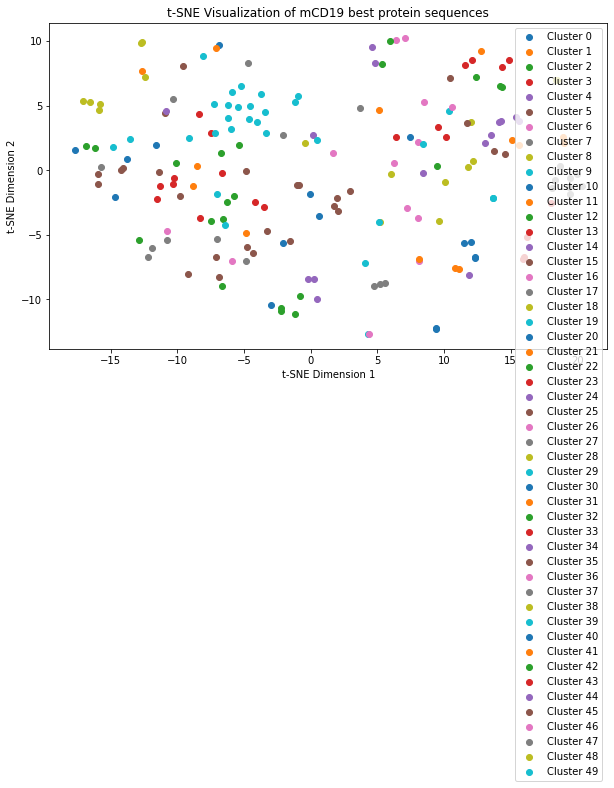

Cluster 0: 3 sequences
Scaffold Names: MQMF, CQZA
Cluster 1: 3 sequences
Scaffold Names: SGQM, IFCN, CQZA
Cluster 2: 2 sequences
Scaffold Names: MG14
Cluster 3: 3 sequences
Scaffold Names: 9VA5, 38CJ, GWRV
Cluster 4: 6 sequences
Scaffold Names: AKD0, QXV4, 2RSQ
Cluster 5: 4 sequences
Scaffold Names: SGQM, CQZA, 2RHJ
Cluster 6: 2 sequences
Scaffold Names: GWRV, 6YCV
Cluster 7: 1 sequences
Scaffold Names: GA87
Cluster 8: 2 sequences
Scaffold Names: GA87, Q084
Cluster 9: 3 sequences
Scaffold Names: ABT7, 82ZM
Cluster 10: 2 sequences
Scaffold Names: 6QXO, W2KZ
Cluster 11: 2 sequences
Scaffold Names: 6YCV, CQZA
Cluster 12: 8 sequences
Scaffold Names: UBKJ, GA87, 2RHJ, SGQM, CQZA
Cluster 13: 2 sequences
Scaffold Names: AKD0, IFCN
Cluster 14: 2 sequences
Scaffold Names: GA87, D0MZ
Cluster 15: 4 sequences
Scaffold Names: W2KZ
Cluster 16: 3 sequences
Scaffold Names: 82ZM, D0MZ, MQMF
Cluster 17: 8 sequences
Scaffold Names: C92R
Cluster 18: 7 sequences
Scaffold Names: CUWJ, QXV4, BDWE, EPA3, MNY3

,Unnamed: 0,level_0,index,mpnn,plddt,i_ptm,i_pae,rmsd,ddg,rg,...,cms,vbuns_bound,vbuns_unbound,vbuns_int,sbuns_bound,sbuns_unbound,sbuns_int,af_binder_plddt,af_pae_int_tot,af_rmsd
clusterid,,,,,,,,,,,,,,,,,,,,,
0,414.000000,999.666667,15242.666667,1.297681,0.883338,0.865755,7.223378,0.952227,-71.229333,14.744306,...,803.352051,21.666667,22.333333,-0.666667,24.000000,22.000000,2.000000,81.444118,9.554206,3.445517
1,403.000000,879.000000,17053.666667,1.243149,0.886402,0.865254,7.345343,1.358634,-67.876000,14.833281,...,770.654704,19.000000,20.333333,-1.333333,21.333333,19.666667,1.666667,81.291621,9.631136,2.727874
2,350.000000,1020.000000,17495.500000,1.232226,0.883675,0.859051,7.430158,0.566517,-72.388500,14.733306,...,818.874146,20.000000,21.500000,-1.500000,18.000000,17.000000,1.000000,80.643039,9.703681,3.652021
3,461.000000,1381.333333,9967.666667,1.155131,0.874074,0.858935,7.339976,1.471025,-62.521333,12.336187,...,709.182576,16.000000,18.000000,-2.000000,20.000000,18.666667,1.333333,81.513725,9.911055,3.209864
4,265.666667,581.500000,5343.000000,1.176227,0.893835,0.865056,7.147426,0.796051,-65.716500,10.668996,...,694.611165,16.000000,16.666667,-0.666667,19.500000,18.666667,0.833333,82.407765,9.791293,3.227429
5,358.500000,698.000000,14494.000000,1.237990,0.890213,0.866434,7.295077,1.454410,-72.597250,14.788644,...,786.273453,19.500000,20.250000,-0.750000,24.000000,21.500000,2.500000,81.403490,9.540702,3.273985
6,272.000000,1206.500000,12182.000000,1.158120,0.879384,0.867736,7.299072,1.758403,-78.698500,12.164276,...,835.232330,16.000000,18.000000,-2.000000,27.500000,23.500000,4.000000,85.990667,8.998202,3.410011
7,437.000000,360.000000,15962.000000,1.305528,0.897210,0.858008,7.358251,1.317580,-67.706000,14.852349,...,785.246521,16.000000,17.000000,-1.000000,22.000000,21.000000,1.000000,81.133412,9.776876,3.248613
8,271.500000,976.500000,17631.500000,1.317251,0.881783,0.875821,7.099532,1.137914,-80.428000,14.567209,...,895.154541,20.000000,20.500000,-0.500000,21.500000,18.500000,3.000000,82.286157,9.753828,3.008185


In [9]:
filtered["seq_split"] = filtered["seq"].apply(lambda x: x.split("/")[-1])

num_clusters=50

seqs=filtered["seq_split"].to_list()
#matrix = np.asarray([np.frombuffer(seq.encode(), dtype=np.uint8) for seq in seqs])
max_length = max(len(seq) for seq in seqs)
padded_seqs = [seq.ljust(max_length, 'N') for seq in seqs]
matrix = np.asarray([np.frombuffer(seq.encode(), dtype=np.uint8) for seq in padded_seqs])
clusterid, error, nfound = kcluster(matrix, nclusters=num_clusters)

# Apply t-SNE to the matrix to reduce the dimensionality and visualize the sequences.
tsne = TSNE(n_components=2, random_state=42)
embedded_matrix = tsne.fit_transform(matrix)

# Create a scatter plot of the embedded points and label them with cluster IDs.
plt.figure(figsize=(10, 6))
for cluster in range(num_clusters):
    cluster_points = embedded_matrix[clusterid == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

plt.title(f"t-SNE Visualization of {input} best protein sequences")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend()
#plt.savefig(f"output/{input}/filtered_sequences/tsne_binders.png")
plt.show()

# Add cluster id to dataframe
filtered["clusterid"]=clusterid
#filtered.to_csv(f"output/{input}/filtered_sequences/2_filtered_binders_clus.csv", index=False)

cluster_counts = Counter(filtered['clusterid'])

# Group the DataFrame by 'clusterid' and get unique scaffold names for each group
unique_scaffold_names = filtered.groupby('clusterid')['diff'].unique()

# Iterate over the groups and print both cluster counts and unique scaffold names
for cluster_id, scaffold_names in unique_scaffold_names.items():
    print(f"Cluster {cluster_id}: {cluster_counts[cluster_id]} sequences")
    print(f'Scaffold Names: {", ".join(scaffold_names)}')

# Calculate average cluster metrics
average_metrics_by_cluster = filtered.groupby('clusterid').mean()
#average_metrics_by_cluster.to_csv(f"output/{input}/filtered_sequences/2_cluster_average.csv", index=False)
average_metrics_by_cluster

# Output final dataframe and binders
Code below will create folders with best [12, 24, 48 ..] binders and metrics.
Make sure to change cluster ratios based on the results above!

In [10]:
total_numbers = [50,100,150]

# Initialize an empty list to collect scaffold_filtered DataFrames


for total_sequences in total_numbers:
    scaffolds_len = len(filtered["diff"].unique())
    all_scaffold_filtered = []
    for scaffold in filtered["diff"].unique():
        scaffold_filtered = filtered[filtered["diff"] == scaffold]
        sequences_to_take = int(total_sequences / scaffolds_len + 0.5)
        scaffold_filtered = scaffold_filtered.head(sequences_to_take)
        print(f"Scaffold: {scaffold}, Sequences to take: {sequences_to_take}")
        
        # Append scaffold_filtered DataFrame to the list
        all_scaffold_filtered.append(scaffold_filtered)

    # Concatenate all scaffold_filtered DataFrames into final_dataframe
    final_dataframe = pd.concat(all_scaffold_filtered)

    binder_pdbs_path = f"output/{input}/filtered_sequences/final_results/binders_{total_sequences}/binder_{total_sequences}_pdbs"
    os.makedirs(binder_pdbs_path, exist_ok=True)
    filename = f"output/{input}/filtered_sequences/final_results/binders_{total_sequences}/final_binders_{total_sequences}.csv"
    final_dataframe.to_csv(filename, index=False)

    for _, row in final_dataframe.iterrows():
        pdb_path = row["model_path"]

        if os.path.exists(pdb_path) and os.path.isfile(pdb_path):
            pdb_filename = os.path.basename(pdb_path)
            destination_path = os.path.join(binder_pdbs_path, pdb_filename)
            shutil.copy(pdb_path, destination_path)
        else:
            print(f"File not found: {pdb_path}")

    print(f"DataFrame for {total_sequences} sequences saved to {filename}")

Scaffold: TXLC, Sequences to take: 1
Scaffold: CUWJ, Sequences to take: 1
Scaffold: SB12, Sequences to take: 1
Scaffold: 6QXO, Sequences to take: 1
Scaffold: QXV4, Sequences to take: 1
Scaffold: GWRV, Sequences to take: 1
Scaffold: GM59, Sequences to take: 1
Scaffold: MVZP, Sequences to take: 1
Scaffold: AT1I, Sequences to take: 1
Scaffold: AKD0, Sequences to take: 1
Scaffold: OKSA, Sequences to take: 1
Scaffold: MQMF, Sequences to take: 1
Scaffold: ABT7, Sequences to take: 1
Scaffold: CM2E, Sequences to take: 1
Scaffold: UBKJ, Sequences to take: 1
Scaffold: MG14, Sequences to take: 1
Scaffold: GA87, Sequences to take: 1
Scaffold: R2L3, Sequences to take: 1
Scaffold: CQZA, Sequences to take: 1
Scaffold: PVBQ, Sequences to take: 1
Scaffold: KI2G, Sequences to take: 1
Scaffold: IFCN, Sequences to take: 1
Scaffold: BDWE, Sequences to take: 1
Scaffold: 2K5F, Sequences to take: 1
Scaffold: 00AE, Sequences to take: 1
Scaffold: ZT9Z, Sequences to take: 1
Scaffold: T0QQ, Sequences to take: 1
S

In [59]:
filtered["scaffold_name"].unique()

array(['4D4P_pd', '2T0M_pd', 'L7TM_pd'], dtype=object)

Scaffold: 4D4P_pd, Total Sequences: 51, Sequences to take: 3
Scaffold: 4D4P_pd, Total Sequences: 51, Sequences to take: 7
Scaffold: 4D4P_pd, Total Sequences: 51, Sequences to take: 15
Scaffold: 2T0M_pd, Total Sequences: 40, Sequences to take: 3
Scaffold: 2T0M_pd, Total Sequences: 40, Sequences to take: 7
Scaffold: 2T0M_pd, Total Sequences: 40, Sequences to take: 15
Scaffold: L7TM_pd, Total Sequences: 15, Sequences to take: 3
Scaffold: L7TM_pd, Total Sequences: 15, Sequences to take: 7
Scaffold: L7TM_pd, Total Sequences: 15, Sequences to take: 15
DataFrame for 12 sequences saved to output/CD45/filtered_sequences/final_results/binders_12/final_binders_12.csv
DataFrame for 24 sequences saved to output/CD45/filtered_sequences/final_results/binders_24/final_binders_24.csv
DataFrame for 48 sequences saved to output/CD45/filtered_sequences/final_results/binders_48/final_binders_48.csv


### other scaffolds

In [75]:
new_other_seq = pd.read_csv("/home/tsatler/RFdif/ClusterProteinDesign/scripts/binder_design/output/CD45/filtered_sequences/other/stats.csv", delimiter=";", header=1)
new_other_seq

,level_0,index,score,plddt,i_ptm,i_pae,i_con,rmsd,model_path,input_pdb,...,dG,dSASA,dG_dSASA_ratio,int_unsat_hbonds,int_hbonds,hyd_contacts,shape_comp,ddg_score,ddg_dsasa_100,ddgscore_dsasa_100
0,6656,15650,0.938849,0.948379,0.897571,6.402125,1.748177,0.610525,output/5fmv_domain3-4/opt_binders/binders/5fmv...,output/5fmv_domain3-4/opt_binders/binders/5fmv...,...,-11.417756,1419.502817,-0.804349,7.0,2.0,8.0,0.730116,-44.573582,-3.565192,-3.140084
1,6012,18635,0.620146,0.949821,0.892687,6.556802,1.706465,0.194243,output/5fmv_domain3-4/opt_binders/binders/5fmv...,output/5fmv_domain3-4/opt_binders/binders/5fmv...,...,14.745972,1380.435903,1.068211,11.0,2.0,7.0,0.688978,-45.839116,-3.703323,-3.320626
2,7203,14234,0.566605,0.947555,0.893287,6.370740,1.712524,0.228130,output/5fmv_domain3-4/opt_binders/binders/5fmv...,output/5fmv_domain3-4/opt_binders/binders/5fmv...,...,72.313913,1393.980216,5.187585,11.0,1.0,8.0,0.648218,-42.952482,-3.672505,-3.081284
3,2777,20149,0.558008,0.957252,0.898240,6.274981,1.655755,0.284202,output/5fmv_domain3-4/opt_binders/binders/5fmv...,output/5fmv_domain3-4/opt_binders/binders/5fmv...,...,41.781513,1378.001936,3.032036,12.0,1.0,7.0,0.675505,-44.215079,-3.642811,-3.208637
4,6089,7311,0.611378,0.949616,0.893010,6.450777,1.710389,0.271164,output/5fmv_domain3-4/opt_binders/binders/5fmv...,output/5fmv_domain3-4/opt_binders/binders/5fmv...,...,56.065544,1400.766793,4.002489,11.0,1.0,7.0,0.661088,-43.167257,-3.642077,-3.081688
5,5947,20201,0.556906,0.949994,0.894093,6.413862,1.701892,0.320820,output/5fmv_domain3-4/opt_binders/binders/5fmv...,output/5fmv_domain3-4/opt_binders/binders/5fmv...,...,114.422784,1420.467620,8.055290,8.0,0.0,7.0,0.676967,-41.782507,-3.641195,-2.941461
6,7006,14294,0.542688,0.947865,0.891099,6.491175,1.723147,0.224487,output/5fmv_domain3-4/opt_binders/binders/5fmv...,output/5fmv_domain3-4/opt_binders/binders/5fmv...,...,60.906963,1398.527412,4.355078,11.0,1.0,7.0,0.646354,-43.635885,-3.630962,-3.120131
7,5127,20169,0.674446,0.952414,0.897353,6.320350,1.669022,0.279404,output/5fmv_domain3-4/opt_binders/binders/5fmv...,output/5fmv_domain3-4/opt_binders/binders/5fmv...,...,54.378165,1398.254132,3.889004,11.0,2.0,8.0,0.667757,-47.551372,-3.624806,-3.400767
8,7349,18671,0.557568,0.947368,0.891600,6.596428,1.723198,0.249942,output/5fmv_domain3-4/opt_binders/binders/5fmv...,output/5fmv_domain3-4/opt_binders/binders/5fmv...,...,18.388672,1384.524239,1.328158,11.0,1.0,7.0,0.673593,-43.520569,-3.624639,-3.143359
9,5381,18567,0.614900,0.951708,0.893030,6.468930,1.700862,0.194906,output/5fmv_domain3-4/opt_binders/binders/5fmv...,output/5fmv_domain3-4/opt_binders/binders/5fmv...,...,28.796804,1383.146213,2.081978,11.0,1.0,7.0,0.675219,-44.512690,-3.622249,-3.218220


In [80]:
new_other_seq["seq_split"] = new_other_seq["seq"].apply(lambda x: x.split("/")[-1])

num_clusters=2

seqs=new_other_seq["seq_split"].to_list()

In [81]:
new_other_seq["seq_split"]

0     DEEWRKRTLEAVRAKDKAGIFESLYETLEEYDKTKDEELKELARLL...
1     MYLVIAKDADPEKAILVAKAAGLEDIEVEDGNVYIYAETKSKAEQV...
2     MYLVIAENADEKKAILVAEAAGLKDIKVENGNVYVYAETKEKAEQV...
3     MYLVVAYNADAEKAILVAEAAGLTDIEVKDGNVYVRAETKEKAEQV...
4     MYLVIAKNADIEKAVLVAEAAGLTDIRVENGDVLIYAPTKEKAEQV...
5     MYLVTAYNADEEKAILVAEAAGLTDIEVKDGNVYIYADTKEKAEQV...
6     MYLVIAENADAEKAILVAEAAGLKDIEVKDGNVYIYAETKEKAEQV...
7     MYLVIAENADVEKAELVARAAGLTDIEVKDGNVYVYAKTKQKAEQV...
8     MYKVIAENADPEKAILVAEAAGLTDIEVEDGNVYIYAETKEKAEQV...
9     MYLVTAVNADAEKAILVAEAAGLTDIEVKDGNVYIYADTKEKAEQV...
10    MYLVKAKNADPEKAILVAEAAGLKDIEVKDGDVYIYAETKEKAEQV...
11    MYLVTAHNADKEKAILVAEAAGLKDIRVENGNVYIYAETKEKAEQV...
12    MYKVIAENADEEKAILVAEAAGLKDIEVKDGDVYIYAETKEKAEQV...
13    MYLVIAKNADIEKAVLVAEAAGLTDIRVENGNVYIYAETKEKAEQV...
14    MYLVIAENADPEKAILVAEAAGLTDIEVRDGNVYIYADTKEKAEQV...
15    MYLVTAKNADEKKAILVAEAAGLTDIEVKDGNVYVRAETKEKAEQV...
16    MYLVTAYNADEEKSILVAEAAGLKDIEVENGNVYIYAPTEEKAKQV...
17    MYKVIAENADEEKAILVAEAAGLKDIEVKDGNVYIYAETKEK

In [90]:
destination_path = "/home/tsatler/RFdif/ClusterProteinDesign/scripts/binder_design/output/CD45/filtered_sequences/batch1"
os.makedirs(destination_path, exist_ok=True)

# for i,row in new_other_seq.head(2).iterrows():
#     model_path=row["model_path"]
#     model_name=model_path.split("/")[-1]
#     new_model_path=f"{destination_path}/{model_name}"
#     shutil.copyfile(model_path, new_model_path)

new_other_seq.head(2).to_csv(f"{destination_path}/other.csv", index=False)